In [145]:
# !pip install opencv-python
# ! pip install tensorflow

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import numpy as np
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import shutil
from sklearn.svm import LinearSVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

In [146]:
train_pneumonia_folder = r'x_ray\chest_xray\train\PNEUMONIA'
train_pneumonia_files = glob.glob(os.path.join(train_pneumonia_folder, '*.jpeg'))

train_normal_folder = r'x_ray\chest_xray\train\NORMAL'
train_normal_files = glob.glob(os.path.join(train_normal_folder, '*.jpeg'))

In [147]:
test_pneumonia_folder = r'x_ray\chest_xray\test\PNEUMONIA'
test_pneumonia_files = glob.glob(os.path.join(test_pneumonia_folder, '*.jpeg'))

test_normal_folder = r'x_ray\chest_xray\test\NORMAL'
test_normal_files = glob.glob(os.path.join(test_normal_folder, '*.jpeg'))

In [148]:
val_pneumonia_folder = r'x_ray\chest_xray\val\PNEUMONIA'
val_pneumonia_files = glob.glob(os.path.join(val_pneumonia_folder, '*.jpeg'))

val_normal_folder = r'x_ray\chest_xray\val\NORMAL'
val_normal_files = glob.glob(os.path.join(val_normal_folder, '*.jpeg'))

### Pre-process the Images

#### Rename and concat all the train data (pneumonia & normal files)

In [149]:
# Rename the files to include "pneumonia" in the filename
def rename_files(files, label):
            
    for file in files:
        directory, filename = os.path.split(file)
        new_filename = f'{label}_{filename}'
        new_filepath = os.path.join(directory, new_filename)

        if os.path.isfile(file) and label not in file:
            os.rename(file, new_filepath)

In [150]:
rename_files(train_pneumonia_files, 'pneumonia')
train_pneumonia_renamed_files = glob.glob(os.path.join(train_pneumonia_folder, '**', '*.jpeg'), recursive=True)

rename_files(train_normal_files, 'normal')
train_normal_renamed_files = glob.glob(os.path.join(train_normal_folder, '**', '*.jpeg'), recursive=True)

In [151]:
rename_files(test_pneumonia_files, 'pneumonia')
test_pneumonia_renamed_files = glob.glob(os.path.join(test_pneumonia_folder, '**', '*.jpeg'), recursive=True)

rename_files(test_normal_files, 'normal')
test_normal_renamed_files = glob.glob(os.path.join(test_normal_folder, '**', '*.jpeg'), recursive=True)

In [152]:
rename_files(val_pneumonia_files, 'pneumonia')
val_pneumonia_renamed_files = glob.glob(os.path.join(val_pneumonia_folder, '**', '*.jpeg'), recursive=True)

rename_files(val_normal_files, 'normal')
val_normal_renamed_files = glob.glob(os.path.join(val_normal_folder, '**', '*.jpeg'), recursive=True)

In [153]:
# Merge the images from both pneumonia and normal dir
def merge_images(folder_name, normal_files, pneumonia_files): 
    
    if folder_name == 'train': 
        merged_dir = r'x_ray\chest_xray\train\merged_images'
    
    elif folder_name == 'test':
        merged_dir = r'x_ray\chest_xray\test\merged_images'
    
    elif folder_name == 'val':
        merged_dir = r'x_ray\chest_xray\val\merged_images'
    
    os.makedirs(merged_dir, exist_ok=True)

    # Copy files from the first directory to the merged directory
    for file in pneumonia_files:
        shutil.copy(file, merged_dir)

    # Copy files from the second directory to the merged directory
    for file in normal_files:
        shutil.copy(file, merged_dir)

    # List all files in the merged directory to verify
    merged_files = glob.glob(os.path.join(merged_dir, '*.jpeg'))
    
    return merged_files

In [154]:
train_files = merge_images('train', train_normal_renamed_files, train_pneumonia_renamed_files)

test_files = merge_images('test', test_normal_renamed_files, test_pneumonia_renamed_files)

val_files = merge_images('val', val_normal_renamed_files, val_pneumonia_renamed_files)

In [155]:
# Preprocess Images: Read, resize, and normalize the images
def preprocess_and_extract_hog(image_path):
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))  # Resize to a fixed size
    features, hog_image = hog(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    
    # Reshape the data to be 2D for SVM
    features_reshape = features.reshape(len(features), -1)
    
    return features_reshape

In [156]:
# Create feature matrix and labels for training data
def feature_matrix_labels(files):
    
    X = []
    y = []

    for file in files:
        if 'pneumonia' in file.lower():
            y.append(1)  # Label for pneumonia
        else:
            y.append(0)  # Label for normal

        features = preprocess_and_extract_hog(file)
        X.append(features)

    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [157]:
# Create feature matrix and labels for training data
X_train, y_train = feature_matrix_labels(train_files)

# Create feature matrix and labels for testing data
X_test, y_test = feature_matrix_labels(test_files)

# Create feature matrix and labels for validation data
X_val, y_val = feature_matrix_labels(val_files)

## SVM MODEL

#### Combine Training and Validation Data

In [158]:
# Combine training and validation data for hyperparameter tuning
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

### 1. Regular SVM model 

#### Grid Search for Hyperparameter Tuning

In [159]:
# Define a parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5, scoring='accuracy', return_train_score=True)

#### Train the Final Model

In [160]:
# Train the SVM model with hyperparameter tuning using cross-validation
grid_search.fit(X_train_val_flat, y_train_val)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

clf = grid_search.best_estimator_

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


#### Test the Model

In [161]:
# Make predictions on the test set
y_test_pred = clf.predict(X_test_flat)

# Evaluate the model on the test data
test_accuracy_1 = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy_1}')

print('Classification Report (Test Data):')
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.7674050632911392
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.97      0.40      0.57       242
           1       0.73      0.99      0.84       390

    accuracy                           0.77       632
   macro avg       0.85      0.70      0.71       632
weighted avg       0.82      0.77      0.74       632



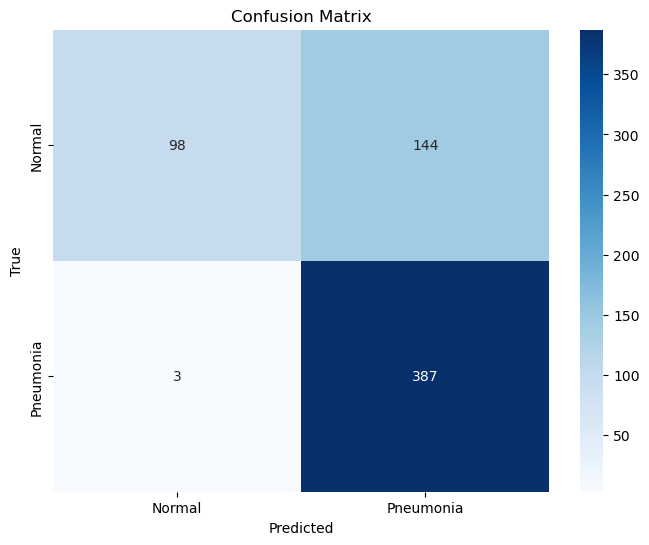

In [162]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 2. SVM model with L1 & L2 regularization

#### Grid Search for Hyperparameter Tuning

In [163]:
# Define a parameter grid for hyperparameter tuning including L1 and L2 regularization
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [False, True]  # Dual should be False for l1 penalty
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svm.LinearSVC(), param_grid, cv=5, scoring='accuracy')

#### Train the Final Model

In [165]:
# Train the SVM model with hyperparameter tuning
grid_search.fit(X_train_val_flat, y_train_val)

# Get the best parameters and train the final model
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

clf = grid_search.best_estimator_

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number 

Best Parameters: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}


#### Test the Model

In [167]:
# Make predictions on the test set
y_test_pred = clf.predict(X_test_flat)

# Evaluate the model on the test data
test_accuracy_2 = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy_2}')

print('Classification Report (Test Data):')
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.7626582278481012
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.98      0.39      0.56       242
           1       0.72      0.99      0.84       390

    accuracy                           0.76       632
   macro avg       0.85      0.69      0.70       632
weighted avg       0.82      0.76      0.73       632



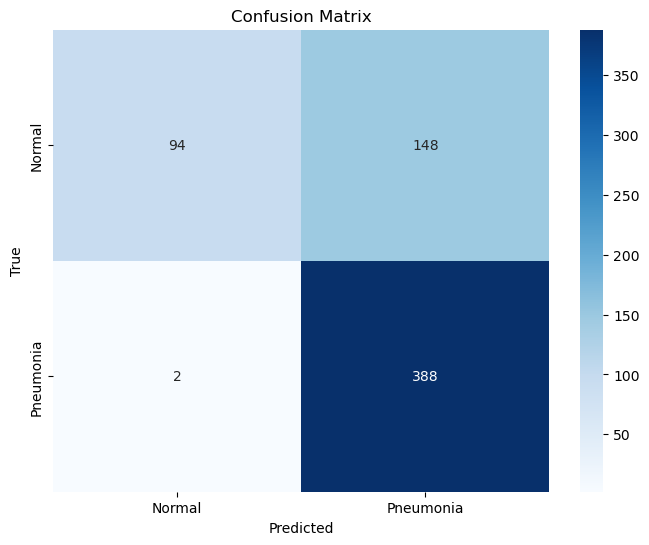

In [168]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The model got precision of 0.98 for class 0 means that when the model predicts 'no pneumonia', it is correct 98% of the time.
recall of 0.99 for class 1 means that 99% of the actual pneumonia cases were correctly identified by the model.

The model is very good at identifying pneumonia cases (class 1), with a high recall of 0.99.
The model struggles with identifying non-pneumonia cases (class 0), as indicated by the lower recall of 0.39.

The results mean that the model is very conservative when it comes to predicting pneumonia, resulting in a high rate of correct pneumonia predictions but a lot of false positives for non-pneumonia cases. This is evident from the high precision and recall for class 1 but low recall for class 0.

## 2-layers CNN model

#### Prepare your data

In [169]:
# Encode labels
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)
y_test_categorical = to_categorical(y_test)

In [170]:
# Define a function to preprocess the images
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, (42, 42))  # Resize the image to 42x42
        img_normalized = img_resized / 255.0  # Normalize pixel values to [0, 1]
        processed_images.append(img_normalized)
    return np.array(processed_images)

# Preprocess the images
X_train_reshape = preprocess_images(X_train).reshape(-1, 42, 42, 1)
X_val_reshape = preprocess_images(X_val).reshape(-1, 42, 42, 1)
X_test_reshape = preprocess_images(X_test).reshape(-1, 42, 42, 1)

#### Build and compile the CNN model

In [171]:
# Build the CNN model
model = Sequential([
    # First convolutional layer
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(42, 42, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional layer
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten the output and add dense layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

C:\Users\shaha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 40, 40, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 40, 40, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,650 (2.61 MB)

 Trainable params: 683,202 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

#### Train the model using training and validation data

In [172]:
# Train the model
history = model.fit(X_train_reshape, y_train_categorical, epochs=20, validation_data=(X_val_reshape, y_val_categorical))

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.7751 - loss: 0.5151 - val_accuracy: 0.5000 - val_loss: 1.3121
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8895 - loss: 0.2670 - val_accuracy: 0.5000 - val_loss: 1.6089
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9020 - loss: 0.2314 - val_accuracy: 0.5000 - val_loss: 1.1005
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9128 - loss: 0.2137 - val_accuracy: 0.5000 - val_loss: 3.2925
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9220 - loss: 0.1968 - val_accuracy: 0.6875 - val_loss: 0.9283
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9171 - loss: 0.1900 - val_accuracy: 0.5000 - val_loss: 9.1027
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9202 - loss: 0.2069 - val_accuracy: 0.5000 - val_loss: 8.9490
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9293 - loss: 0.1840 - val_acc

#### Evaluate the model using the test data

In [173]:
# Evaluate the model on the test data
loss, accuracy_3 = model.evaluate(X_test_reshape, y_test_categorical)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy_3}')

# Make predictions
y_pred = model.predict(X_test_reshape)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3276 - loss: 3.1391
Test Loss: 1.7542535066604614
Test Accuracy: 0.6376582384109497
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


#### Generate confusion matrix and classification report for the test data

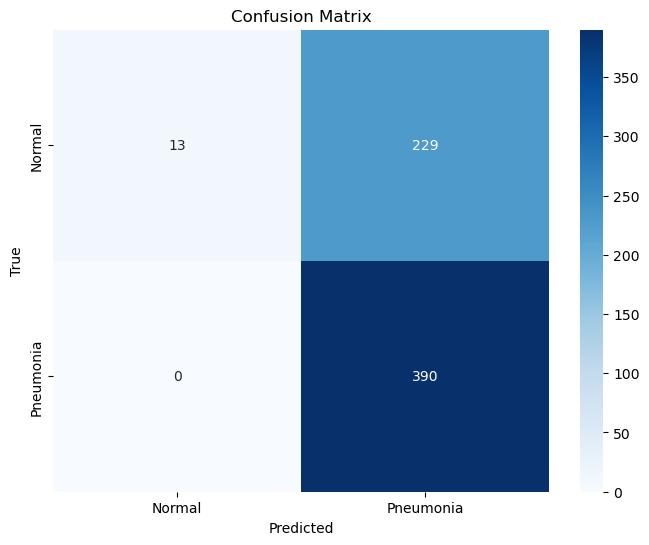

In [174]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Plot training history to visualize the training and validation accuracy and loss

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.05      0.10       242
   Pneumonia       0.63      1.00      0.77       390

    accuracy                           0.64       632
   macro avg       0.82      0.53      0.44       632
weighted avg       0.77      0.64      0.52       632



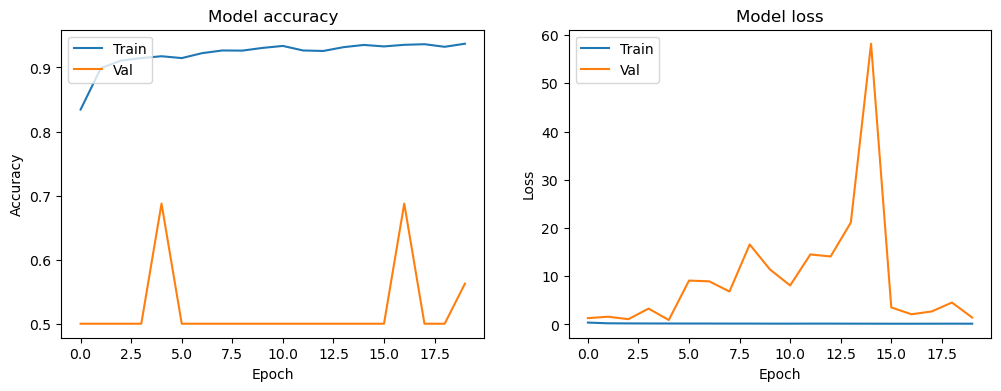

In [175]:
# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

The current results indicate that the model is not performing well on the test data. 
The test accuracy is quite low, and the test loss is high. 
We will try to improve the model's performance on the next section

## Deep network model

### Data Augmentation
Using data augmentation to artificially increasing the size and variability of the training dataset. This can help the model generalize better

In [176]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Fit the generator to the data
datagen.fit(X_train_reshape)

### Increase Model Complexity & Regularization
Adding more layers and increasing the number of filters in the convolutional layers can help the model learn more complex features

Adding L2 regularization can help prevent overfitting

Adding Batch Normalization

In [177]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(42, 42, 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

C:\Users\shaha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 40, 40, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 40, 40, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,274 (1.49 MB)

 Trainable params: 389,314 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

### Learning Rate Scheduling
Using learning rate scheduling can help improve training by adjusting the learning rate during training.

In [178]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history = model.fit(datagen.flow(X_train_reshape, y_train_categorical, batch_size=32),
                    validation_data=(X_val_reshape, y_val_categorical),
                    epochs=50,
                    callbacks=[reduce_lr])

Epoch 1/50
  1/163 ━━━━━━━━━━━━━━━━━━━━ 20:21 8s/step - accuracy: 0.5938 - loss: 6.8684

C:\Users\shaha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.6173 - loss: 5.5747 - val_accuracy: 0.5000 - val_loss: 5.7629 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7713 - loss: 3.0609 - val_accuracy: 0.5000 - val_loss: 4.6349 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7983 - loss: 1.9957 - val_accuracy: 0.4375 - val_loss: 1.8580 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8093 - loss: 1.4332 - val_accuracy: 0.5000 - val_loss: 3.3167 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8249 - loss: 1.0643 - val_accuracy: 0.5000 - val_loss: 1.1567 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8374 - loss: 0.8410 - val_accuracy: 0.5000 - val_loss: 3.1936 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8423 - loss: 0.6958 - va

163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8287 - loss: 0.4593 - val_accuracy: 0.5000 - val_loss: 7.6618 - learning_rate: 0.0010
Epoch 45/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8490 - loss: 0.4255 - val_accuracy: 0.5000 - val_loss: 26.7797 - learning_rate: 0.0010
Epoch 46/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8438 - loss: 0.4352 - val_accuracy: 0.5000 - val_loss: 6.5631 - learning_rate: 0.0010
Epoch 47/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8425 - loss: 0.4286 - val_accuracy: 0.5000 - val_loss: 7.2481 - learning_rate: 0.0010
Epoch 48/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8431 - loss: 0.4256 - val_accuracy: 0.5000 - val_loss: 7.8158 - learning_rate: 0.0010
Epoch 49/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8461 - loss: 0.4402 - val_accuracy: 0.5000 - val_loss: 87.1331 - learning_rate: 0.0010
Epoch 50/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8502 - loss: 0.43

### Transfer Learning
Using a pre-trained model (like VGG16, ResNet, etc.) and fine-tuning it on your dataset can significantly improve performance.

In [179]:
# Preprocess Images: Read, resize, normalize, and convert to RGB
def preprocess_and_convert_to_rgb(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (42, 42))  # Resize to a fixed size
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB
    image_rgb = image_rgb / 255.0  # Normalize to [0, 1] range
    return image_rgb

# Apply this preprocessing to your dataset
X_train_rgb = np.array([preprocess_and_convert_to_rgb(path) for path in train_files])
X_val_rgb = np.array([preprocess_and_convert_to_rgb(path) for path in val_files])
X_test_rgb = np.array([preprocess_and_convert_to_rgb(path) for path in test_files])

#### Train the model 

In [181]:
# Load the VGG16 model, excluding the top (fully connected) layers
base_model = VGG16(include_top=False, input_shape=(42, 42, 3))

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Fit the generator to your data
datagen.fit(X_train_rgb)

# Train the model
history = model.fit(datagen.flow(X_train_rgb, y_train_categorical, batch_size=32),
                    validation_data=(X_val_rgb, y_val_categorical),
                    epochs=50)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 268ms/step - accuracy: 0.7698 - loss: 0.4862 - val_accuracy: 0.6250 - val_loss: 0.5165
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 271ms/step - accuracy: 0.8340 - loss: 0.3637 - val_accuracy: 0.6250 - val_loss: 0.6209
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 258ms/step - accuracy: 0.8538 - loss: 0.3214 - val_accuracy: 0.6875 - val_loss: 0.6787
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 260ms/step - accuracy: 0.8614 - loss: 0.3113 - val_accuracy: 0.6875 - val_loss: 0.7418
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 264ms/step - accuracy: 0.8659 - loss: 0.3098 - val_accuracy: 0.6875 - val_loss: 0.7807
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 262ms/step - accuracy: 0.8710 - loss: 0.2957 - val_accuracy: 0.6875 - val_loss: 0.6698
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 257ms/step - accuracy: 0.8713 - loss: 0.3043 - val_accuracy: 0.6875 - val_loss: 0.7833
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 259ms/step - accuracy: 0.8691 - loss: 0

163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step - accuracy: 0.9067 - loss: 0.2268 - val_accuracy: 0.6250 - val_loss: 0.7972


#### Evaluate the model using the test data

In [182]:
# Evaluate the model on the test data
test_loss, test_accuracy_4 = model.evaluate(X_test_rgb, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy_4}')

# Make predictions
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.8820 - loss: 0.3745
Test Loss: 0.313412070274353
Test Accuracy: 0.8829113841056824
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step


#### Generate confusion matrix and classification report for the test data

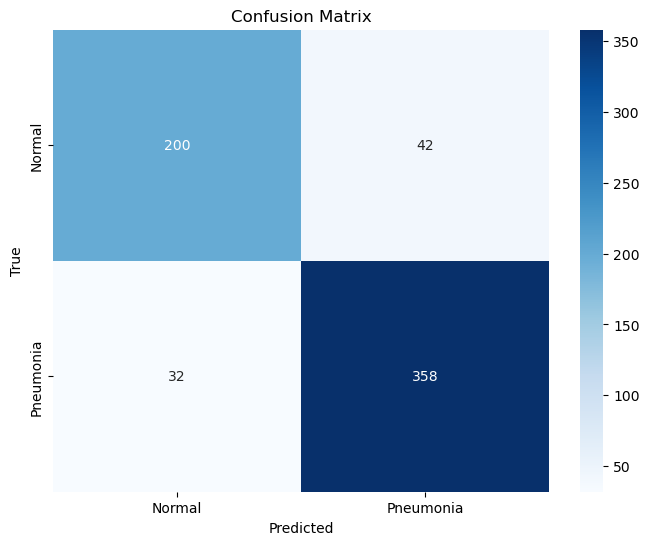

In [183]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Plot training history to visualize the training and validation accuracy and loss

Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.83      0.84       242
   Pneumonia       0.90      0.92      0.91       390

    accuracy                           0.88       632
   macro avg       0.88      0.87      0.88       632
weighted avg       0.88      0.88      0.88       632



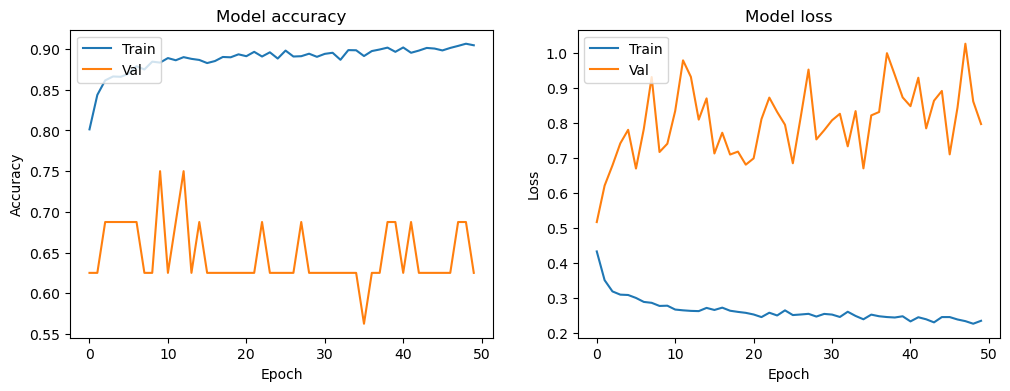

In [184]:
# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

- **Test Loss**: 0.3134
- **Test Accuracy**: 0.8829 (approximately 88.3%)

- **Training Accuracy**: The training accuracy steadily increases and stabilizes around 90%.
- **Validation Accuracy**: The validation accuracy shows fluctuations but stabilizes around 70-75%.
- **Training Loss**: The training loss decreases consistently, indicating effective learning.
- **Validation Loss**: The validation loss shows fluctuations, indicating some instability or overfitting.

The final model shows good performance on the test set with an accuracy of 88.13%. The precision and recall for the "Pneumonia" class are both high, indicating that the model is effective at identifying pneumonia cases. 

#### Example of the prediction

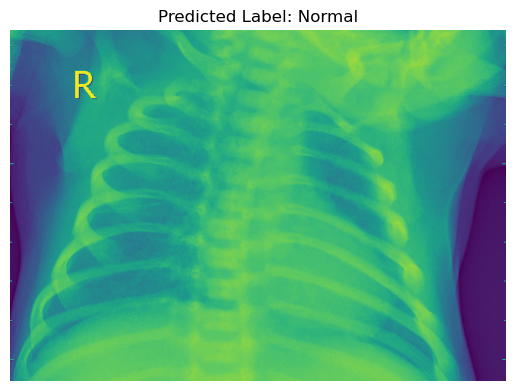

In [185]:
# Display example image with his prediction
image_path = r'x_ray\chest_xray\test\merged_images\pneumonia_person1685_virus_2903.jpeg'

if y_pred_classes[-1] == 1:
    pred_label = 'Pneumonia'
else:
    pred_label = 'Normal'
    
img = mpimg.imread(image_path)
plt.imshow(img)
plt.title(os.path.basename(f'Predicted Label: {pred_label}'))
plt.axis('off')  
plt.show()

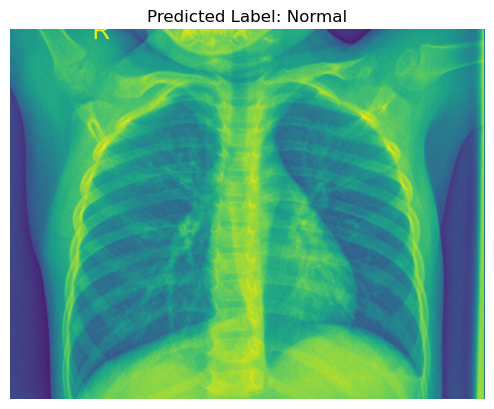

In [186]:
# Display example image with his prediction
image_path = r'x_ray\chest_xray\test\merged_images\normal_IM-0009-0001.jpeg'

if y_pred_classes[5] == 1:
    pred_label = 'Pneumonia'
else:
    pred_label = 'Normal'
    
img = mpimg.imread(image_path)
plt.imshow(img)
plt.title(os.path.basename(f'Predicted Label: {pred_label}'))
plt.axis('off')  
plt.show()

### Summarize the models results

In [188]:
results_df = pd.DataFrame()

results_df['Model'] = ['Regular SVM', 'SVM with regularization', 'Simple CNN', 'Deep CNN']
results_df['Test Accuracy'] = [test_accuracy_1, test_accuracy_2, accuracy_3, test_accuracy_4]

results_df

,Model,Test Accuracy
0,Regular SVM,0.767405
1,SVM with regularization,0.762658
2,Simple CNN,0.637658
3,Deep CNN,0.882911
